### Composites

In this notebook we'll take a closer look at how `pre_et_look` works internally. To do so, we'll be using a couple of functions that you'd normally not need to touch, because they are called automatically when you run `pywapor.pre_et_look.main`.

First, we'll install pywapor in case it's not installed yet.

In [1]:
!pip install pywapor --quiet

Then we can define some of the basic parameters that were explained in the introduction notebook. In this case we'll look at the Fayoum region again, for a period of two months.

In [1]:
import pywapor
import xarray as xr
import matplotlib.pyplot as plt
import numpy as np

project_folder = r"/Users/hmcoerver/pywapor_notebooks_3"
latlim = [28.9, 29.7]
lonlim = [30.2, 31.2]
timelim = ["2021-06-01", "2021-08-01"]

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


One of the first things happening when you run `pre_et_look`, is the creation of a more precise definition of the composites (from here on also referred to as time_bins) for which `pre_et_look` will prepare the data to be used by `et_look`.

The default value for the `bin_length` in `pywapor.pre_et_look.main` is `"DEKAD"`, which creates three composites per month (of roughly 10 days each), just like much of the WaPOR data. We'll go with this default value for now. The variable `bins` contains the edges off these bins.

Normally you wouldn't have to run this code yourself, its just shown here to explain what happens inside the `pre_et_look` code.

In [2]:
bin_length = "DEKAD"

bins = pywapor.general.compositer.time_bins(timelim, bin_length)

for i, (start, end) in enumerate(zip(bins[:-1], bins[1:])):
    print(f"Composite {i + 1} starts at {start} and ends at {end}.\n")

Composite 1 starts at 2021-06-01T00:00:00.000000000 and ends at 2021-06-11T00:00:00.000000000.

Composite 2 starts at 2021-06-11T00:00:00.000000000 and ends at 2021-06-21T00:00:00.000000000.

Composite 3 starts at 2021-06-21T00:00:00.000000000 and ends at 2021-07-01T00:00:00.000000000.

Composite 4 starts at 2021-07-01T00:00:00.000000000 and ends at 2021-07-11T00:00:00.000000000.

Composite 5 starts at 2021-07-11T00:00:00.000000000 and ends at 2021-07-21T00:00:00.000000000.

Composite 6 starts at 2021-07-21T00:00:00.000000000 and ends at 2021-08-01T00:00:00.000000000.



Besides defining the time_bins, `pre_et_look` also downloads data. In this example we'll look solely at NDVI data (from MOD13 and MYD13). So instead of using the default (`"level_1"`, `"level_2"` or `"level_2_v3"`) `sources`, we'll define some custom values here. Like this, `pre_et_look` will only process `ndvi`.

In [3]:
sources = {
    'ndvi': {'products': [{'source': 'MODIS',
                            'product_name': 'MOD13Q1.061',
                            'enhancers': 'default'},
                          {'source': 'MODIS', 
                          'product_name': 'MYD13Q1.061', 
                          'enhancers': 'default'}],
            'composite_type': 'mean',
            'temporal_interp': False,
            'spatial_interp': 'nearest'}
        }

Now we can run `pre_et_look`. Since we'll only download and process `ndvi`, this should go pretty quick.

In [4]:
dss, sources = pywapor.collect.downloader.collect_sources(project_folder, sources, latlim, lonlim, timelim)

--> Collecting `ndvi` from `MODIS.MOD13Q1.061`.
    --> Applying 'mask_qa' to `ndvi`.                  
    --> Saving merged data.
        > peak-memory-usage: 11.6MB, execution-time: 0:00:02.425868.
        > chunksize|dimsize: [time: 5|5, y: 403|403, x: 506|506]
        > timesize: 5 [2021-06-02T00:00, ..., 2021-08-05T00:00]
--> Collecting `ndvi` from `MODIS.MYD13Q1.061`.
    --> Applying 'mask_qa' to `ndvi`.                  
    --> Saving merged data.
        > peak-memory-usage: 9.3MB, execution-time: 0:00:02.093121.
        > chunksize|dimsize: [time: 4|4, y: 403|403, x: 506|506]
        > timesize: 4 [2021-06-10T00:00, ..., 2021-07-28T00:00]


`dss` is a dictionary with the paths to the downloaded netCDF files for each product we've requested.

In [5]:
dss

{('MODIS',
  'MOD13Q1.061'): '/Users/hmcoerver/pywapor_notebooks_3/MODIS/MOD13Q1.061.nc',
 ('MODIS',
  'MYD13Q1.061'): '/Users/hmcoerver/pywapor_notebooks_3/MODIS/MYD13Q1.061.nc'}

We'll define a function that can plot some values in these datasets at a point of interest.

In [6]:
def plot_timeseries(dss, latlon, composites = None, var = "ndvi", unit = "-"):
    fig = plt.figure(figsize = (6,4), dpi=150)
    ax = fig.gca()

    if not isinstance(composites, type(None)):
        x = composites.time_bins.values
        y = composites.sel(y = latlon[0], x = latlon[1], method = "nearest")[var].values
        width = np.diff(bins) 
        ax.bar(x, y, width = width, align = "edge", color = "lightblue", edgecolor = "darkblue", zorder = 8, alpha = 0.8)

    for product, ds_fh in dss.items():
        ds = xr.open_dataset(ds_fh, decode_coords = "all")
        y = ds.sel(y = latlon[0], x = latlon[1], method = "nearest")[var].values
        x = ds.time.values
        ax.scatter(x, y, label = ".".join(product), zorder = 10)

    ax.legend()
    ax.grid(zorder = 0)
    ax.set_facecolor("lightgray")
    ax.set_xlabel("time")
    ax.set_ylabel(f"{var} [{unit}]")

And then use it.

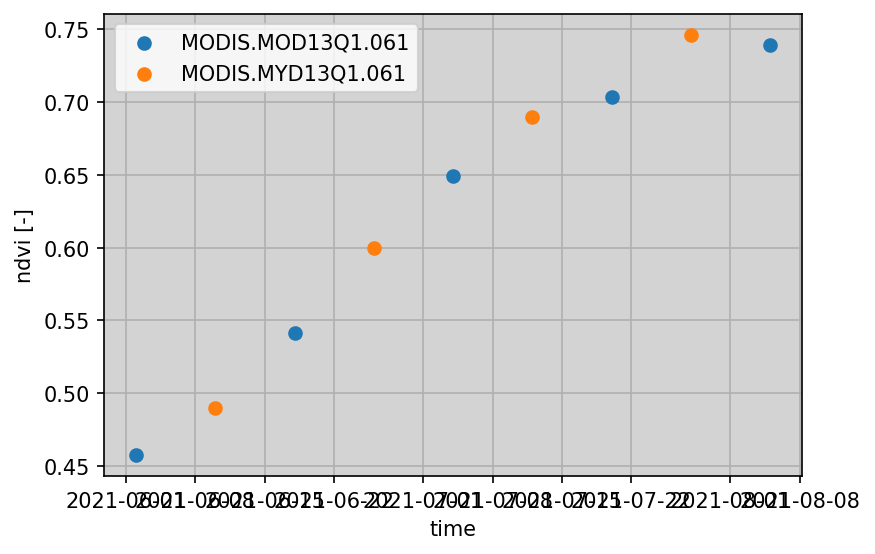

In [7]:
latlon = (29.32301, 30.77599)
plot_timeseries(dss, latlon)

Next, we'll run the functions that turns these seperate measurements into composites (again, normally this is done internally when you run `pywapor.pre_et_look.main`). Note that we pass an empty list here for the `enhancers` argument, see the notebook on enhancers to learn more about this argument. 

In [8]:
enhancers = []
ds_composites = pywapor.general.compositer.main(dss, sources, project_folder, enhancers, bins)

--> Compositing 1 variables.
    --> (1/1) Compositing `ndvi` (mean).
        --> Using `MYD13Q1.061.nc` as reprojecting example.
            > shape: (403, 506), res: 0.0020° x 0.0020°.
        --> Saving `ndvi` composites.
            > peak-memory-usage: 58.6MB, execution-time: 0:00:02.029245.
            > chunksize|dimsize: [time_bins: 6|6, y: 403|403, x: 506|506]
--> Didn't find any products for `is_example`.
--> Creating merged file `et_look_in.nc`.
    > peak-memory-usage: 28.0MB, execution-time: 0:00:02.101097.
    > chunksize|dimsize: [time_bins: 6|6, y: 403|403, x: 506|506]


You'll see two messages in the output. They indicate that no example dataset was found. An example dataset is used to make sure the pixel-size and dataset bounds are the same for all variables and products. When no example dataset is found, the function will automatically search for the dataset with the smallest pixels and use that dataset as an example. Since here we are using only two products with a very similar pixel size, this is not very important here.

The output looks like this.

In [9]:
ds_composites

<xarray.Dataset>
Dimensions:      (time_bins: 6, y: 403, x: 506)
Coordinates:
  * x            (x) float64 30.2 30.2 30.2 30.21 30.21 ... 31.19 31.2 31.2 31.2
  * y            (y) float64 29.7 29.7 29.7 29.69 ... 28.91 28.91 28.9 28.9
    spatial_ref  int64 ...
  * time_bins    (time_bins) datetime64[ns] 2021-06-01 2021-06-11 ... 2021-07-21
Data variables:
    ndvi         (time_bins, y, x) float64 dask.array<chunksize=(6, 403, 506), meta=np.ndarray>

We can make a plot like this.

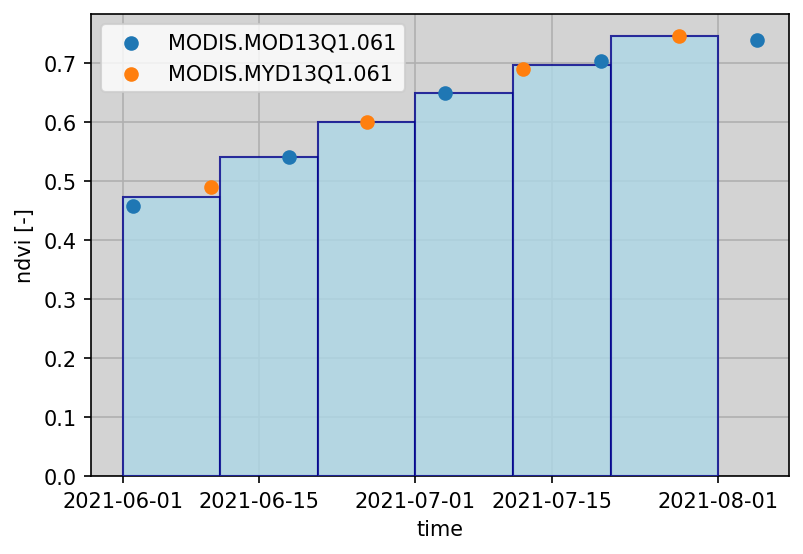

In [10]:
plot_timeseries(dss, latlon, composites = ds_composites)

In the graph we have just created, you should see a couple of things. First of all, there are blue-dots and orange-dots that show available NDVI measurements at our POI, coming from MOD13 and MYD13 respectively. Then there are blue bars that show the composite pixel values at this location. Since our composites are dekadal, the width of the bars is about 10 days (check the x-axis).

Each composite value is the mean of the available measurements within the respective `time_bin`. For example, most of the bars match with some of the measurements. While the first bar, ranging from June 1st till June 11th is exactly in between two measurements, i.e. it’s the mean of the two available measurements.

The composite type is defined using the keyword `composite_type` in the sources variable. Possible values are `"mean"`, `"min"` and `"max"`.

Now let’s adjust our composite_length to create 6-day composites (instead of dekadal) and see what happens.

In [11]:
bin_length = 6
bins = pywapor.general.compositer.time_bins(timelim, bin_length)

for i, (start, end) in enumerate(zip(bins[:-1], bins[1:])):
    print(f"Composite {i + 1} starts at {start} and ends at {end}.\n")

Composite 1 starts at 2021-06-01T00:00:00.000000000 and ends at 2021-06-07T00:00:00.000000000.

Composite 2 starts at 2021-06-07T00:00:00.000000000 and ends at 2021-06-13T00:00:00.000000000.

Composite 3 starts at 2021-06-13T00:00:00.000000000 and ends at 2021-06-19T00:00:00.000000000.

Composite 4 starts at 2021-06-19T00:00:00.000000000 and ends at 2021-06-25T00:00:00.000000000.

Composite 5 starts at 2021-06-25T00:00:00.000000000 and ends at 2021-07-01T00:00:00.000000000.

Composite 6 starts at 2021-07-01T00:00:00.000000000 and ends at 2021-07-07T00:00:00.000000000.

Composite 7 starts at 2021-07-07T00:00:00.000000000 and ends at 2021-07-13T00:00:00.000000000.

Composite 8 starts at 2021-07-13T00:00:00.000000000 and ends at 2021-07-19T00:00:00.000000000.

Composite 9 starts at 2021-07-19T00:00:00.000000000 and ends at 2021-07-25T00:00:00.000000000.

Composite 10 starts at 2021-07-25T00:00:00.000000000 and ends at 2021-07-31T00:00:00.000000000.

Composite 11 starts at 2021-07-31T00:00

And then recalculate the composites.

In [12]:
ds_composites = pywapor.general.compositer.main(dss, sources, project_folder, enhancers, bins)

--> Compositing 1 variables.
    --> (1/1) Compositing `ndvi` (mean).
        --> Using `MYD13Q1.061.nc` as reprojecting example.
            > shape: (403, 506), res: 0.0020° x 0.0020°.
        --> Saving `ndvi` composites.
            > peak-memory-usage: 80.9MB, execution-time: 0:00:02.039768.
            > chunksize|dimsize: [time_bins: 11|11, y: 403|403, x: 506|506]
--> Didn't find any products for `is_example`.
--> Creating merged file `et_look_in_.nc`.
    > peak-memory-usage: 51.3MB, execution-time: 0:00:02.143718.
    > chunksize|dimsize: [time_bins: 11|11, y: 403|403, x: 506|506]


Then create a new plot.

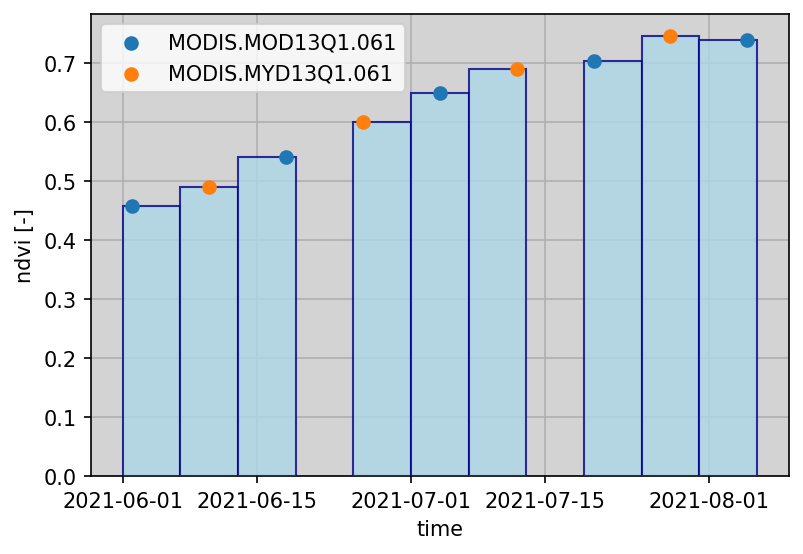

In [13]:
plot_timeseries(dss, latlon, composites = ds_composites)

In the new graph, you’ll see that the blue bars have become smaller (i.e. less wide), since our time_bins are now shorter. As a result, some composites could not be created, because no NDVI measurements were available during that respective epoch. For example, the fourth composite (ranging between 2021-06-19 00:00:00 and 2021-06-25 00:00:00) is missing.

We solve this by applying a temporal interpolation between the available measurements. This is especially suitable for this data, because the MOD13 and MYD13 datasets itself are 16-daily composites, i.e. their measurements can be considered valid for a 16-day period.

In [14]:
sources["ndvi"]["temporal_interp"] = "linear"
ds_composites = pywapor.general.compositer.main(dss, sources, project_folder, enhancers, bins)

--> Compositing 1 variables.
    --> (1/1) Compositing `ndvi` (mean).
        --> Using `MYD13Q1.061.nc` as reprojecting example.
            > shape: (403, 506), res: 0.0020° x 0.0020°.
        --> Saving `ndvi` composites.
            > peak-memory-usage: 82.5MB, execution-time: 0:00:06.065150.
            > chunksize|dimsize: [time_bins: 11|11, y: 403|403, x: 506|506]
--> Didn't find any products for `is_example`.
--> Creating merged file `et_look_in__.nc`.
    > peak-memory-usage: 51.3MB, execution-time: 0:00:02.173311.
    > chunksize|dimsize: [time_bins: 11|11, y: 403|403, x: 506|506]


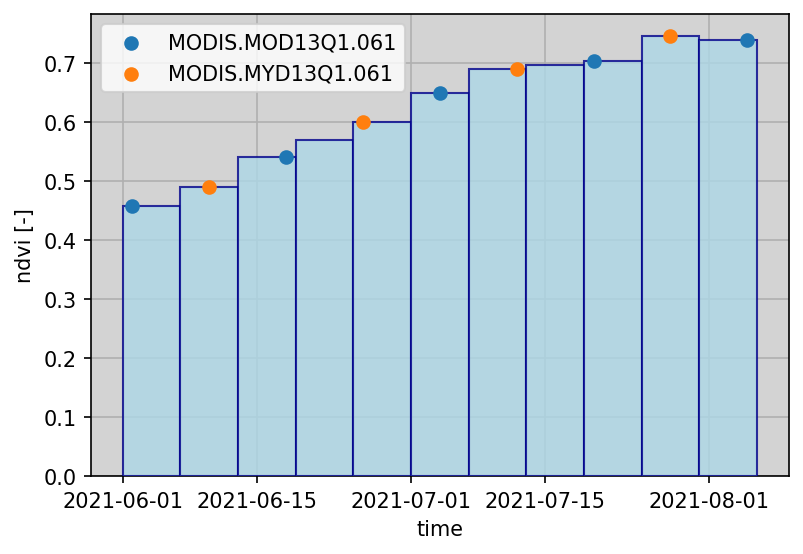

In [15]:
plot_timeseries(dss, latlon, composites = ds_composites)

The two composites that were previously missing are now there! Note that although here we are looking at one pixel, these interpolations are done for the entire domain.

Possible values for temporal_interp are `False`, `"linear"`, `"nearest"`, `"zero"`, `"slinear"`, `"quadratic"` or `"cubic"`. But be aware that some of these can be computationally heavy.